In [1]:
import torch
from torch import nn
from torchvision.models import resnet18, resnet50, alexnet, vgg16
from torchvision.models import convnext_tiny, maxvit_t, mnasnet1_3, regnet_x_400mf,resnext50_32x4d, swin_t
import numpy as np
import seaborn as sns

torch.manual_seed(seed=0)
model = alexnet(weights=None)
state = model.state_dict()
first_weight = list(state.values())[0]
first_key = list(state.keys())[0]
first_item = list(state.items())[0] #key value pairs

for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


features.0.weight 	 torch.Size([64, 3, 11, 11])
features.0.bias 	 torch.Size([64])
features.3.weight 	 torch.Size([192, 64, 5, 5])
features.3.bias 	 torch.Size([192])
features.6.weight 	 torch.Size([384, 192, 3, 3])
features.6.bias 	 torch.Size([384])
features.8.weight 	 torch.Size([256, 384, 3, 3])
features.8.bias 	 torch.Size([256])
features.10.weight 	 torch.Size([256, 256, 3, 3])
features.10.bias 	 torch.Size([256])
classifier.1.weight 	 torch.Size([4096, 9216])
classifier.1.bias 	 torch.Size([4096])
classifier.4.weight 	 torch.Size([4096, 4096])
classifier.4.bias 	 torch.Size([4096])
classifier.6.weight 	 torch.Size([1000, 4096])
classifier.6.bias 	 torch.Size([1000])


In [2]:
from sklearn.decomposition import PCA
import numpy as np
pca = PCA()
x = np.ones((2,2,2,2))
pca.fit(x)


ValueError: Found array with dim 4. Estimator expected <= 2.

0.7436952886256651
0.7515544301735991
0.6504409297725547


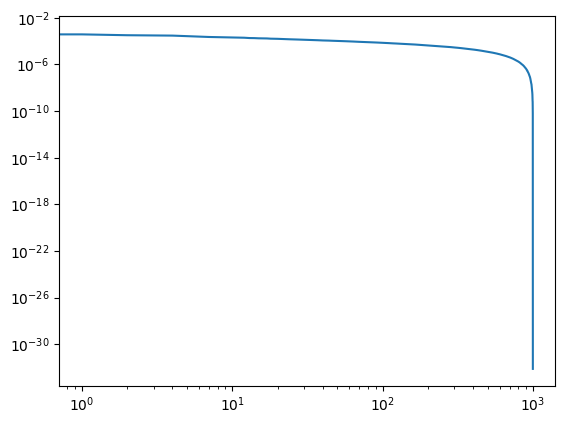

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

np.random.seed(seed=0)

# Set parameters
num_samples = 1000  # Number of samples
k_size = 9 #kernel size
in_size = 24 #from alexnet mp1
num_features = in_size * k_size*k_size  # Number of features
power_law_exponent = -0.5  # Exponent of power law decay
variance_scale = 1  # Scaling factor for eigenvectors' variances
num_components = min(num_features, num_samples)

# Generate principal components
eigenvalues = np.power(np.arange(1, num_samples+1, dtype=float), power_law_exponent) #change to n_components+1
#**this should be min(samples, features)??

eigenvectors = np.random.randn(num_features, num_samples)
#**this should be (n_components, n_features) ??

eigenvectors, _ = np.linalg.qr(eigenvectors)

#eigenvectors = eigenvectors / np.sqrt(np.sum(np.square(eigenvectors), axis=0))  # Normalize columns
# - almost orthogonal but not quite without linalg.qr

# Scale eigenvectors' variances
eigenvectors = eigenvectors * np.sqrt(eigenvalues)[np.newaxis, :] * variance_scale
eigenvectors = eigenvectors.T

# Generate random data
X_rt = np.random.normal(loc=0.0, scale=0.1, size=(num_samples, num_features)) #@ eigenvectors

#X_transformed = (X @ eigenvectors).T

pca_pre = PCA()
pca_pre.fit(X_rt)
X_transformed = pca_pre.transform(X)

pca_pre.components_ = eigenvectors
pca_pre.explained_variance_ = eigenvalues

#pca_pre.mean_ = 
X_new= pca_pre.inverse_transform(X_transformed)

pca_post = PCA()
pca_post.fit(X_new)

plt.loglog(pca_post.explained_variance_)




def get_alpha_E():
    n_pc = pca_post.n_components_
    end = np.log10(n_pc)
    eignum = np.logspace(0, end, num=n_pc).round().astype(int) #or, num=n_pc
    eigspec = pca_post.explained_variance_[eignum - 1]
    logeignum = np.log10(eignum)
    logeigspec = np.log10(eigspec) #.reshape(-1,1)
    linear_fit = LinearRegression().fit(logeignum.reshape(-1,1), logeigspec)
    alpha = -linear_fit.coef_.item()
    return alpha
alpha_E = get_alpha_E()
print(alpha_E)

def get_alpha_R():
    n_pc = pca_post.n_components_
    eignum_bins = np.geomspace(1, n_pc, num=50).round().astype(int)
    pc_index = eignum_bins - 1
    bins = pca_post.explained_variance_[pc_index]

    assigned_bins = np.digitize(pca_post.explained_variance_, bins)

    bin_means = []
    for i in range(0, len(bins)):
        if i in assigned_bins:
            bin_means.append(pca_post.explained_variance_[assigned_bins == i].mean())

    unique_assignments, unique_pcindex, count_unique = np.unique(assigned_bins, return_index=True, return_counts=True)
    solo_pcindex = unique_pcindex[count_unique==1]
    multi_assigned = unique_assignments[count_unique!=1]
    eignum_means = []
    for m in multi_assigned:
        multi_pcind = np.where(assigned_bins==m)[0]
        mean_pcind = multi_pcind.mean()
        eignum_means.append(mean_pcind)
    eignum_fit = np.sort(np.concatenate((solo_pcindex, np.array(eignum_means)))) + 1

    logspec = np.log10(bin_means)
    lognum = np.log10(eignum_fit)

    linear_fit = LinearRegression().fit(lognum.reshape(-1,1), logspec)
    alpha = -linear_fit.coef_.item()
    
    return alpha

alpha_R = get_alpha_R()
print(alpha_R)

def get_alpha_S(ss, trange):
    ''' fit exponent to variance curve'''
    logss = np.log(np.abs(ss))
    y = logss[trange][:,np.newaxis]
    trange += 1
    nt = trange.size
    x = np.concatenate((-np.log(trange)[:,np.newaxis], np.ones((nt,1))), axis=1)
    w = 1.0 / trange.astype(np.float32)[:,np.newaxis]
    b = np.linalg.solve(x.T @ (x * w), (w * x).T @ y).flatten()
    
    alpha = b[0]
    return alpha
alpha_S = get_alpha_S(pca_post.explained_variance_/pca_post.explained_variance_.sum(), np.arange(11,5e2).astype(int))
print(alpha_S)


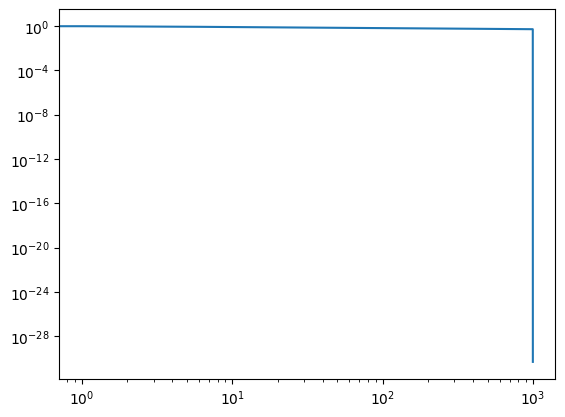

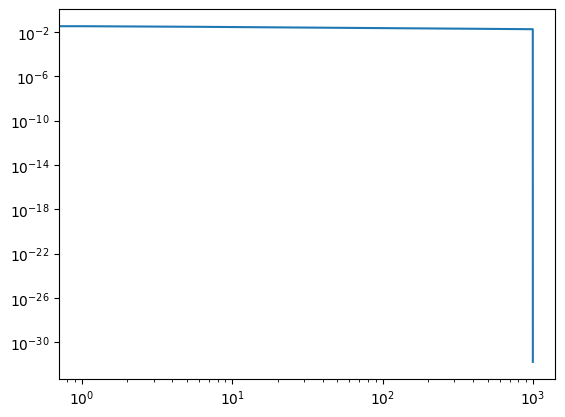

scale check
[0.03529907 0.03529907 0.03529907 0.03529907 0.03529907 0.03529907
 0.03529907 0.03529907 0.03529907 0.03529907 0.03529907 0.03529907
 0.03529907 0.03529907 0.03529907 0.03529907 0.03529907 0.03529907
 0.03529907 0.03529907 0.03529907 0.03529907 0.03529907 0.03529907
 0.03529907 0.03529907 0.03529907 0.03529907 0.03529907 0.03529907
 0.03529907 0.03529907 0.03529907 0.03529907 0.03529907 0.03529907
 0.03529907 0.03529907 0.03529907 0.03529907 0.03529907 0.03529907
 0.03529907 0.03529907 0.03529907 0.03529907 0.03529907 0.03529907
 0.03529907 0.03529907 0.03529907 0.03529907 0.03529907 0.03529907
 0.03529907 0.03529907 0.03529907 0.03529907 0.03529907 0.03529907
 0.03529907 0.03529907 0.03529907 0.03529907 0.03529907 0.03529907
 0.03529907 0.03529907 0.03529907 0.03529907 0.03529907 0.03529907
 0.03529907 0.03529907 0.03529907 0.03529907 0.03529907 0.03529907
 0.03529907 0.03529907 0.03529907 0.03529907 0.03529907 0.03529907
 0.03529907 0.03529907 0.03529907 0.03529907 0.035

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

np.random.seed(seed=0)

# Set parameters
num_samples = 1000  # Number of samples
k_size = 9 #kernel size
in_size = 24 #from alexnet mp1
num_features = in_size * k_size*k_size  # Number of features
power_law_exponent = -0.1  # Exponent of power law decay
variance_scale = 1  # Scaling factor for eigenvectors' variances
num_components = min(num_features, num_samples)


U, _ = np.linalg.qr(np.random.randn(num_samples, num_components))
#U, _ = np.linalg.qr(np.random.normal(loc=0.0, scale=0.1, size=(num_samples, num_samples)))
V, _ = np.linalg.qr(np.random.randn(num_features, num_components))
V_T = V.T
#V_T, _ = np.linalg.qr(np.random.normal(loc=0.0, scale=0.1, size=(num_features, num_features)))

#U = mxm (samples)
#S = mxm
#V = nxm (but transpose = mxn)

#V = vectors
#

eigenvalues = np.power(np.arange(1, num_components+1, dtype=float), power_law_exponent)
S = np.zeros((num_components, num_components))
#S = np.zeros((num_samples, num_features))
np.fill_diagonal(S, val= np.sqrt( (eigenvalues*(num_samples-1)) ))

SVt = S @ V_T
X_SVD = U @ SVt

#X_transformed1 = X_SVD @ V
#X_transformed2 = U @ S
#print(X_transformed1.shape)
#print(X_transformed2.shape)
#print(np.allclose(X_transformed1,X_transformed2))

#pca_xtransformed = PCA()
#pca_xtransformed.fit(X_transformed1)
#print(pca_xtransformed.components_.shape)
#print(pca_xtransformed.explained_variance_[0])
#fig = plt.loglog(pca_xtransformed.explained_variance_)
#plt.show()

#U (SVt) = C x E
            #U = C x k
            #SVt = k x E
            #S = k x k
            #Vt = k x E
            
            #C=1000:
            #U = C x C
            #SVt = C x E
            #S = C x C
            #Vt = C x E
            
            #C=2000:
            #U = C x E
            #SVt = E x E
            #S = E x E
            #Vt = E x E



pca_SVD = PCA()
pca_SVD.fit(X_SVD)
fig = plt.loglog(pca_SVD.explained_variance_)
plt.show()

scale = np.max(X_SVD) * 2
new_X = X_SVD / scale

pca_SVD2 = PCA()
pca_SVD2.fit(new_X)
fig = plt.loglog(pca_SVD2.explained_variance_)
plt.show()

scale_check = pca_SVD2.explained_variance_ /pca_SVD.explained_variance_
print('scale check')
print(scale_check)

#print(pca_SVD.explained_variance_)
#print(pca_SVD2.explained_variance_)



def get_alpha_E(ev):
    n_pc = len(ev)
    end = np.log10(n_pc)
    eignum = np.logspace(0, end, num=n_pc).round().astype(int) #or, num=n_pc
    eigspec = ev[eignum - 1]
    logeignum = np.log10(eignum)
    logeigspec = np.log10(eigspec) #.reshape(-1,1)
    linear_fit = LinearRegression().fit(logeignum.reshape(-1,1), logeigspec)
    alpha = -linear_fit.coef_.item()
    return alpha
alpha_E1 = get_alpha_E(pca_SVD.explained_variance_)
print(alpha_E1)
alpha_E2 = get_alpha_E(pca_SVD2.explained_variance_)
print(alpha_E2)

def get_alpha_R(ev):
    n_pc = len(ev)
    eignum_bins = np.geomspace(1, n_pc, num=50).round().astype(int)
    pc_index = eignum_bins - 1
    bins = ev[pc_index]

    assigned_bins = np.digitize(ev, bins)

    bin_means = []
    for i in range(0, len(bins)):
        if i in assigned_bins:
            bin_means.append(ev[assigned_bins == i].mean())

    unique_assignments, unique_pcindex, count_unique = np.unique(assigned_bins, return_index=True, return_counts=True)
    solo_pcindex = unique_pcindex[count_unique==1]
    multi_assigned = unique_assignments[count_unique!=1]
    eignum_means = []
    for m in multi_assigned:
        multi_pcind = np.where(assigned_bins==m)[0]
        mean_pcind = multi_pcind.mean()
        eignum_means.append(mean_pcind)
    eignum_fit = np.sort(np.concatenate((solo_pcindex, np.array(eignum_means)))) + 1

    logspec = np.log10(bin_means)
    lognum = np.log10(eignum_fit)

    linear_fit = LinearRegression().fit(lognum.reshape(-1,1), logspec)
    alpha = -linear_fit.coef_.item()
    
    return alpha
alpha_R1 = get_alpha_R(pca_SVD.explained_variance_)
print(alpha_R1)
alpha_R2 = get_alpha_R(pca_SVD2.explained_variance_)
print(alpha_R2)

def get_alpha_S(ss, trange):
    ''' fit exponent to variance curve'''
    logss = np.log(np.abs(ss))
    y = logss[trange][:,np.newaxis]
    trange += 1
    nt = trange.size
    x = np.concatenate((-np.log(trange)[:,np.newaxis], np.ones((nt,1))), axis=1)
    w = 1.0 / trange.astype(np.float32)[:,np.newaxis]
    b = np.linalg.solve(x.T @ (x * w), (w * x).T @ y).flatten()
    
    alpha = b[0]
    return alpha
alpha_S1 = get_alpha_S(pca_SVD.explained_variance_/pca_SVD.explained_variance_.sum(), np.arange(11,5e2).astype(int))
print(alpha_S1)
alpha_S2 = get_alpha_S(pca_SVD2.explained_variance_/pca_SVD2.explained_variance_.sum(), np.arange(11,5e2).astype(int))
print(alpha_S2)




[1.         0.70710678 0.57735027 ... 0.02269214 0.0226863  0.02268046]
[1.09119179e-02 8.36120106e-03 6.46341021e-03 5.54662108e-03
 5.31707120e-03 4.95428527e-03 4.84246254e-03 4.39083487e-03
 4.29054812e-03 4.22955074e-03 4.02123515e-03 3.96127787e-03
 3.84477814e-03 3.68897685e-03 3.64847883e-03 3.51481572e-03
 3.46977765e-03 3.37958812e-03 3.35115178e-03 3.30093846e-03
 3.21208275e-03 3.18450719e-03 3.14000162e-03 3.11026942e-03
 3.03603744e-03 2.99033432e-03 2.95745674e-03 2.90813705e-03
 2.87626419e-03 2.84946121e-03 2.82078145e-03 2.80386867e-03
 2.78106524e-03 2.76275883e-03 2.71969851e-03 2.70979380e-03
 2.66786527e-03 2.65969357e-03 2.63300123e-03 2.62857198e-03
 2.60268784e-03 2.57150709e-03 2.56960555e-03 2.53303935e-03
 2.49818470e-03 2.48012777e-03 2.46473947e-03 2.45847283e-03
 2.42240824e-03 2.41740164e-03 2.39702619e-03 2.38786398e-03
 2.37195447e-03 2.36764002e-03 2.34329145e-03 2.33530511e-03
 2.31123975e-03 2.30845896e-03 2.29165966e-03 2.27959731e-03
 2.26572191e-

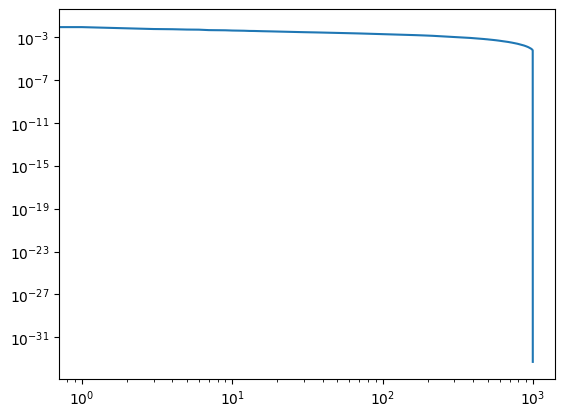

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

np.random.seed(seed=0)

# Set parameters
num_samples = 1000  # Number of samples
k_size = 9 #kernel size
in_size = 24 #from alexnet mp1
num_features = in_size * k_size*k_size  # Number of features
power_law_exponent = -0.5  # Exponent of power law decay
variance_scale = 1  # Scaling factor for eigenvectors' variances
num_components = min(num_features, num_samples)

# Generate principal components
eigenvalues = np.power(np.arange(1, num_features+1, dtype=float), power_law_exponent) #change to n_components+1
#**this should be min(samples, features)??

eigenvectors = np.random.randn(num_features, num_features)
#**this should be (n_components, n_features) ??

eigenvectors, _ = np.linalg.qr(eigenvectors)
#eigenvectors = eigenvectors / np.sqrt(np.sum(np.square(eigenvectors), axis=0))  # Normalize columns
# - almost orthogonal but not quite without linalg.qr

# Scale eigenvectors' variances
eigenvectors = eigenvectors * np.sqrt(eigenvalues)[np.newaxis, :] * variance_scale

# Generate random data
X = np.random.normal(loc=0.0, scale=0.1, size=(num_samples, num_features)) @ eigenvectors


pca = PCA()
pca.fit(X)

plt.loglog(pca.explained_variance_)
print(eigenvalues)
print(pca.explained_variance_)


def get_alpha_E():
    n_pc = pca.n_components_
    end = np.log10(n_pc)
    eignum = np.logspace(0, end, num=n_pc).round().astype(int) #or, num=n_pc
    eigspec = pca.explained_variance_[eignum - 1]
    logeignum = np.log10(eignum)
    logeigspec = np.log10(eigspec) #.reshape(-1,1)
    linear_fit = LinearRegression().fit(logeignum.reshape(-1,1), logeigspec)
    alpha = -linear_fit.coef_.item()
    return alpha

alpha_E = get_alpha_E()
print(alpha_E)


def get_alpha_R():
    n_pc = pca.n_components_
    eignum_bins = np.geomspace(1, n_pc, num=50).round().astype(int)
    pc_index = eignum_bins - 1
    bins = pca.explained_variance_[pc_index]

    assigned_bins = np.digitize(pca.explained_variance_, bins)

    bin_means = []
    for i in range(0, len(bins)):
        if i in assigned_bins:
            bin_means.append(pca.explained_variance_[assigned_bins == i].mean())

    unique_assignments, unique_pcindex, count_unique = np.unique(assigned_bins, return_index=True, return_counts=True)
    solo_pcindex = unique_pcindex[count_unique==1]
    multi_assigned = unique_assignments[count_unique!=1]
    eignum_means = []
    for m in multi_assigned:
        multi_pcind = np.where(assigned_bins==m)[0]
        mean_pcind = multi_pcind.mean()
        eignum_means.append(mean_pcind)
    eignum_fit = np.sort(np.concatenate((solo_pcindex, np.array(eignum_means)))) + 1

    logspec = np.log10(bin_means)
    lognum = np.log10(eignum_fit)

    linear_fit = LinearRegression().fit(lognum.reshape(-1,1), logspec)
    alpha = -linear_fit.coef_.item()
    return alpha

alpha_R = get_alpha_R()
print(alpha_R)


def get_alpha_S(ss, trange):
    ''' fit exponent to variance curve'''
    logss = np.log(np.abs(ss))
    y = logss[trange][:,np.newaxis]
    trange += 1
    nt = trange.size
    x = np.concatenate((-np.log(trange)[:,np.newaxis], np.ones((nt,1))), axis=1)
    w = 1.0 / trange.astype(np.float32)[:,np.newaxis]
    b = np.linalg.solve(x.T @ (x * w), (w * x).T @ y).flatten()
    
    alpha = b[0]
    return alpha

alpha_S = get_alpha_S(pca.explained_variance_/pca.explained_variance_.sum(), np.arange(11,5e2).astype(int))
print(alpha_S)



(1944, 1944)
(1944, 1000)
(1000, 1944)
[1.         0.70710678 0.57735027 ... 0.02269214 0.0226863  0.02268046]
[5.22577846e-04 3.84633042e-04 3.18981742e-04 2.82210535e-04
 2.50525202e-04 2.28147180e-04 2.24866240e-04 2.09259264e-04
 1.95915668e-04 1.78448888e-04 1.74160029e-04 1.69532862e-04
 1.67102167e-04 1.59218128e-04 1.54464139e-04 1.52862496e-04
 1.46724198e-04 1.43893300e-04 1.38281911e-04 1.37006967e-04
 1.33881531e-04 1.32282396e-04 1.28483828e-04 1.25951809e-04
 1.24577302e-04 1.23940703e-04 1.20999933e-04 1.18327548e-04
 1.16311290e-04 1.15565468e-04 1.13719396e-04 1.12631790e-04
 1.10100595e-04 1.09543669e-04 1.07409279e-04 1.06640937e-04
 1.05612651e-04 1.04572653e-04 1.03762480e-04 1.03553934e-04
 1.01667022e-04 1.00510212e-04 9.84268259e-05 9.80626564e-05
 9.67206966e-05 9.58642149e-05 9.50886198e-05 9.42514565e-05
 9.38912462e-05 9.19450463e-05 9.14459077e-05 9.10868343e-05
 9.06970493e-05 8.98869820e-05 8.83098515e-05 8.79524950e-05
 8.76685501e-05 8.68203894e-05 8.61

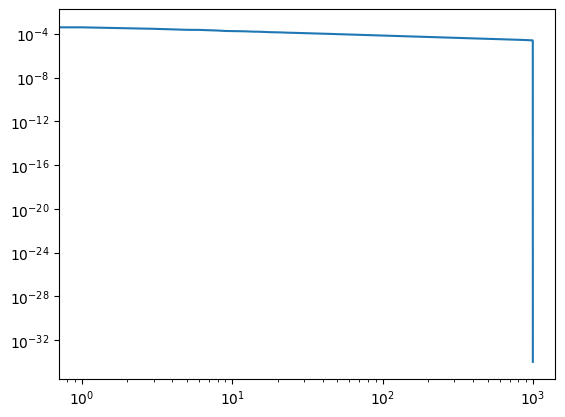

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

np.random.seed(seed=0)

# Set parameters
num_samples = 1000  # Number of samples
k_size = 9 #kernel size
in_size = 24 #from alexnet mp1
num_features = in_size * k_size*k_size  # Number of features
power_law_exponent = -0.5  # Exponent of power law decay
variance_scale = 1  # Scaling factor for eigenvectors' variances
num_components = min(num_features, num_samples)

# Generate principal components
eigenvalues = np.power(np.arange(1, num_features+1, dtype=float), power_law_exponent) #change to n_components+1
#**this should be min(samples, features)??

eigenvectors = np.random.randn(num_features, num_features)
#**this should be (n_components, n_features) ??

eigenvectors, _ = np.linalg.qr(eigenvectors)
print(eigenvectors.shape)
#eigenvectors = eigenvectors / np.sqrt(np.sum(np.square(eigenvectors), axis=0))  # Normalize columns
# - almost orthogonal but not quite without linalg.qr

# Scale eigenvectors' variances
eigenvectors = eigenvectors * np.sqrt(eigenvalues)[np.newaxis, :] * variance_scale

# Generate random data
X = np.random.normal(loc=0.0, scale=0.1, size=(num_features, num_samples))
Y, _ = np.linalg.qr(X)
print(Y.shape)
W = Y.T @ eigenvectors
print(W.shape)

pca = PCA()
pca.fit(W)

plt.loglog(pca.explained_variance_)
print(eigenvalues)
print(pca.explained_variance_)


def get_alpha_E():
    n_pc = pca.n_components_
    end = np.log10(n_pc)
    eignum = np.logspace(0, end, num=n_pc).round().astype(int) #or, num=n_pc
    eigspec = pca.explained_variance_[eignum - 1]
    logeignum = np.log10(eignum)
    logeigspec = np.log10(eigspec) #.reshape(-1,1)
    linear_fit = LinearRegression().fit(logeignum.reshape(-1,1), logeigspec)
    alpha = -linear_fit.coef_.item()
    return alpha

alpha_E = get_alpha_E()
print(alpha_E)


def get_alpha_R():
    n_pc = pca.n_components_
    eignum_bins = np.geomspace(1, n_pc, num=50).round().astype(int)
    pc_index = eignum_bins - 1
    bins = pca.explained_variance_[pc_index]

    assigned_bins = np.digitize(pca.explained_variance_, bins)

    bin_means = []
    for i in range(0, len(bins)):
        if i in assigned_bins:
            bin_means.append(pca.explained_variance_[assigned_bins == i].mean())

    unique_assignments, unique_pcindex, count_unique = np.unique(assigned_bins, return_index=True, return_counts=True)
    solo_pcindex = unique_pcindex[count_unique==1]
    multi_assigned = unique_assignments[count_unique!=1]
    eignum_means = []
    for m in multi_assigned:
        multi_pcind = np.where(assigned_bins==m)[0]
        mean_pcind = multi_pcind.mean()
        eignum_means.append(mean_pcind)
    eignum_fit = np.sort(np.concatenate((solo_pcindex, np.array(eignum_means)))) + 1

    logspec = np.log10(bin_means)
    lognum = np.log10(eignum_fit)

    linear_fit = LinearRegression().fit(lognum.reshape(-1,1), logspec)
    alpha = -linear_fit.coef_.item()
    return alpha

alpha_R = get_alpha_R()
print(alpha_R)


def get_alpha_S(ss, trange):
    ''' fit exponent to variance curve'''
    logss = np.log(np.abs(ss))
    y = logss[trange][:,np.newaxis]
    trange += 1
    nt = trange.size
    x = np.concatenate((-np.log(trange)[:,np.newaxis], np.ones((nt,1))), axis=1)
    w = 1.0 / trange.astype(np.float32)[:,np.newaxis]
    b = np.linalg.solve(x.T @ (x * w), (w * x).T @ y).flatten()
    
    alpha = b[0]
    return alpha

alpha_S = get_alpha_S(pca.explained_variance_/pca.explained_variance_.sum(), np.arange(11,5e2).astype(int))
print(alpha_S)



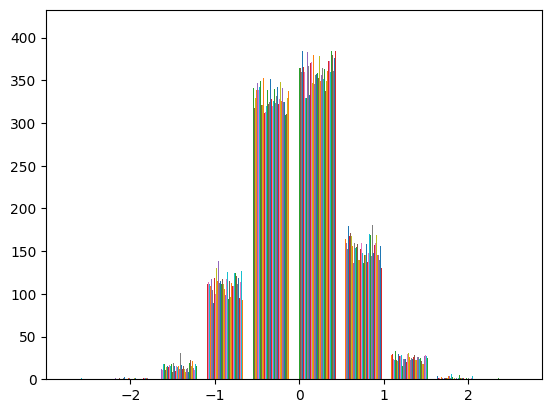

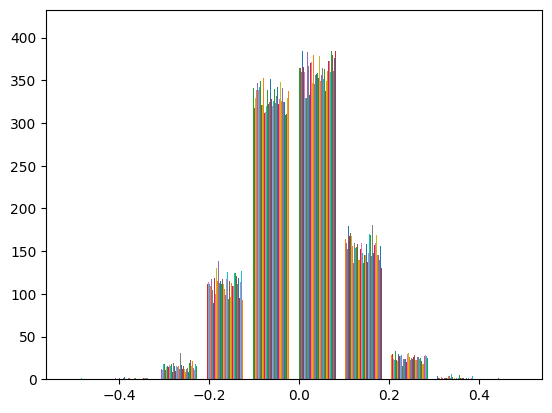

In [30]:

#scale_check = eigenvalues[0:len(pca.explained_variance_)] / np.square(pca.explained_variance_)
#print(scale_check)

#scale_check = pca_SVD.explained_variance_ / pca_SVD2.explained_variance_
#print(scale_check)

#plt.hist(X)
#plt.show()

plt.hist(X_SVD)
plt.show()

plt.hist(new_X)
plt.show()

#plt.hist(X_rt)
#plt.show()

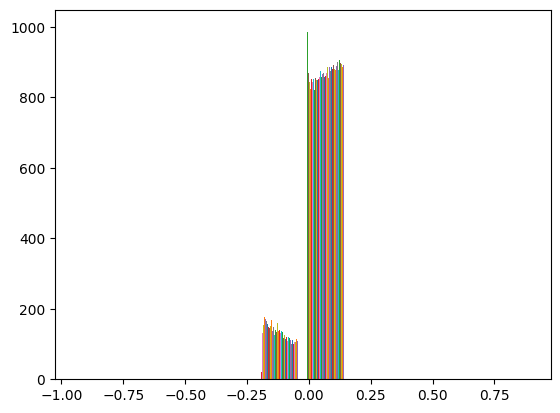

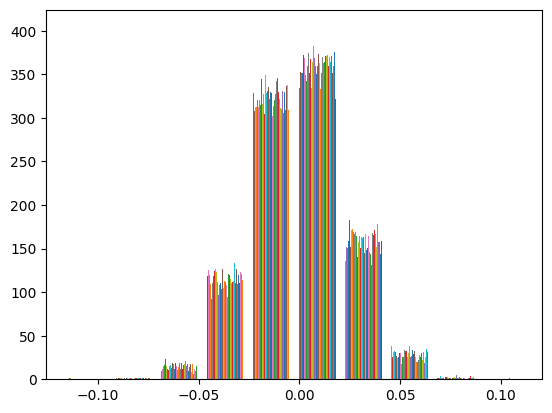

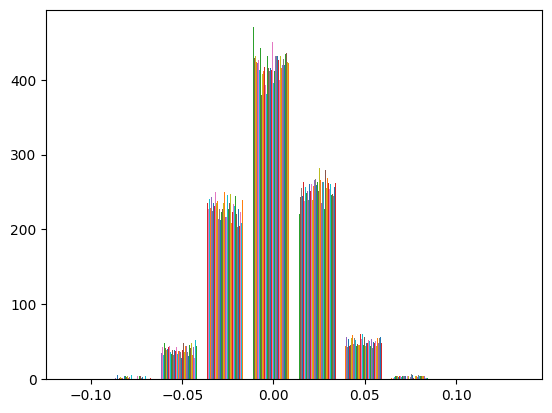

In [8]:
plt.hist(pca.components_)
plt.show()

plt.hist(pca_SVD.components_)
plt.show()

plt.hist(pca_post.components_)
plt.show()

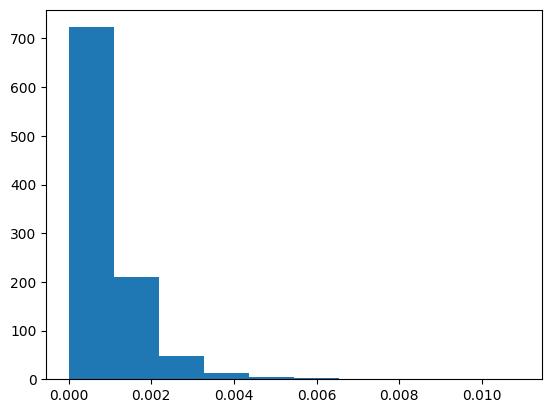

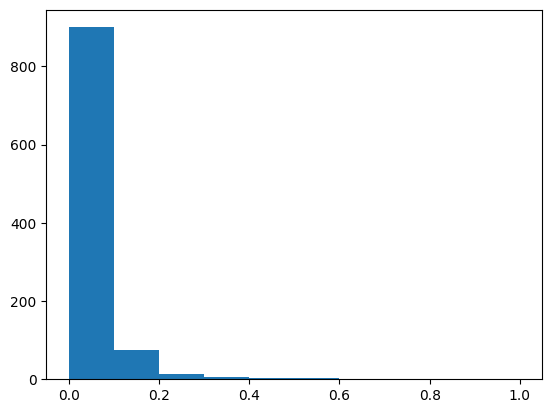

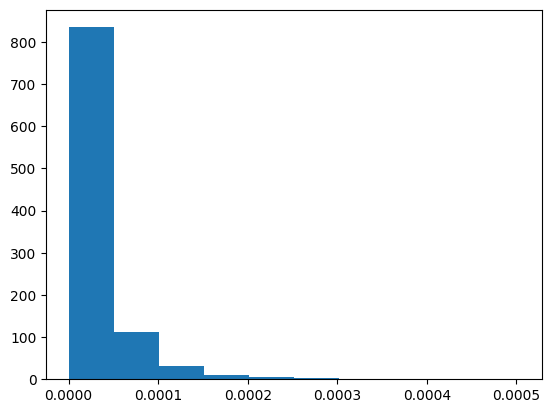

In [7]:
plt.hist(pca.explained_variance_)
plt.show()

plt.hist(pca_SVD.explained_variance_)
plt.show()

plt.hist(pca_post.explained_variance_)
plt.show()

In [27]:
a = np.random.normal(loc=0.0, scale=10.0, size=(3,3))
print(a)

#row_sums = a.sum(axis=1)
#new_matrix = a / row_sums[:, np.newaxis]
#print(new_matrix)

max = np.sum(np.absolute(a))
print(max)
new_matrix = a / max
print(new_matrix)

[[  4.22653158   7.22468497  -0.73569423]
 [  4.51179846  -5.12483955  -8.64175526]
 [ -3.41522124   2.03942654 -12.63193428]]
48.55188611936123
[[ 0.08705185  0.14880338 -0.01515274]
 [ 0.09292736 -0.10555387 -0.1779901 ]
 [-0.07034168  0.04200509 -0.26017391]]


1000


In [3]:
n_pc = len(pca.explained_variance_)
eignum = np.geomspace(1, n_pc, num=50).round().astype(int)
index = eignum - 1
bins = pca.explained_variance_[index]

bin_index = np.digitize(pca.explained_variance_, bins)

bin_means = []
for i in range(0, len(bins)):
    if i in bin_index:
        bin_means.append(pca.explained_variance_[bin_index == i].mean())

bin_unique, ind_unique, count_unique = np.unique(bin_index, return_index=True, return_counts=True)
ind_single = ind_unique[count_unique==1]
bin_multi = bin_unique[count_unique!=1]
pc_means1 = []
pc_means2 = []
for m in bin_multi:
    multi = bin_index[bin_index==m]
    multi_ind1 = np.where(bin_index==m)[0]
    multi_ind2 = np.where(bin_index==m)[0] + 1
    mean_ind1 = multi_ind1.mean()
    mean_ind2 = multi_ind2.mean()
    pc_means1.append(mean_ind1)
    pc_means2.append(mean_ind2)

num_plot1 = np.sort(np.concatenate((ind_single, np.array(pc_means1)))) + 1
num_plot2 = np.sort(np.concatenate((ind_single+1, np.array(pc_means2))))
print(num_plot1)
print(num_plot2)

logspec = np.log10(bin_means)
lognum = np.log10(num_plot1)


[  1.    2.    3.    4.    5.    6.    7.    8.    9.5  11.   12.5  14.5
  16.5  18.5  21.   24.5  28.   32.   37.   42.5  49.   56.5  65.   74.5
  85.5  98.5 113.5 130.5 150.  172.5 198.5 228.5 263.  303.  349.  401.5
 462.  532.  612.5 705.  812.  935. ]
[  1.    2.    3.    4.    5.    6.    7.    8.    9.5  11.   12.5  14.5
  16.5  18.5  21.   24.5  28.   32.   37.   42.5  49.   56.5  65.   74.5
  85.5  98.5 113.5 130.5 150.  172.5 198.5 228.5 263.  303.  349.  401.5
 462.  532.  612.5 705.  812.  935. ]


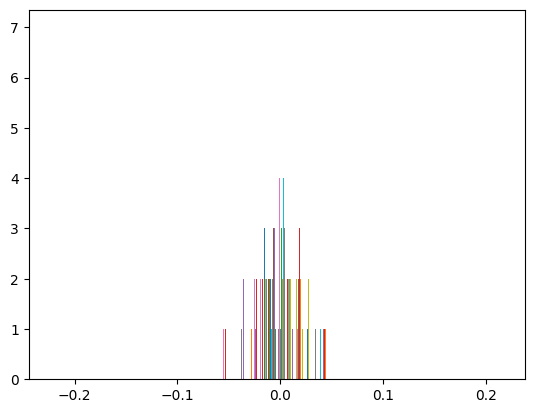

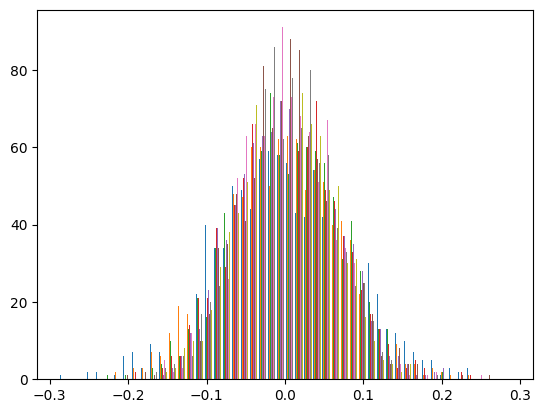

In [63]:
#plt.hist(eigenvectors)
#plt.show()

plt.hist(X)
plt.show()

plt.hist(X)
plt.show()
Y = X.flatten()
#plt.hist(Y, bins=1000)
#plt.show()

Z = X[1,:]
#plt.hist(Z, bins=50)
#plt.show()


Z = X[1:10,:]
plt.hist(Z, bins=50)
plt.show()
Z = X[:,1:10]
plt.hist(Z, bins=50)
plt.show()

In [2]:
import pandas as pd
#from matplotlib import pyplot as plt
an = pd.read_csv('/home/wtownle1/encoder_dimensionality/tests/AtlasNetWeights')
c2 = an.iloc[[1]]
print(c2.min(axis=1))
print(c2.max(axis=1))
print(c2.mean(axis=1))

#sns.distplot(weights)
#plt.hist(c2)
#plt.show()

1   -0.02268
dtype: float64
1    1.0
dtype: float64
1    0.000809
dtype: float64


In [1]:
import torch
from torch import nn
from torchvision.models import resnet18, resnet50, alexnet, vgg16
from torchvision.models import convnext_tiny, maxvit_t, mnasnet1_3, regnet_x_400mf,resnext50_32x4d, swin_t
import numpy as np
import seaborn as sns

torch.manual_seed(seed=0)
model = alexnet(weights=None)

def xavier(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight)
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)

model.apply(xavier)

weights = []
for key in model.state_dict():
    val = np.array(model.state_dict()[key])
    val = np.ndarray.flatten(val)
    val = np.ndarray.tolist(val)
    weights = weights + val

sns.distplot(weights)


/home/wtownle1/.conda/envs/encoder-dimensionality/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



In [18]:
def models():
    torch.manual_seed(seed=0)
    
    #model = resnet18(weights=None)
    #yield model
    
    #model = resnet50(weights=None)
    #yield model
    
    model = alexnet(weights=None)
    yield model
    
    model = mnasnet1_3(weights=None)
    yield model
    
    model = regnet_x_400mf(weights=None)
    yield model
    
    model = resnext50_32x4d(weights=None)
    yield model
    
    model = convnext_tiny(weights = None)
    yield model
    
    model = vgg16(weights = None)
    yield model

for model in models():
    print(model.__class__.__name__)
    for param in model.state_dict():
        print(param, "\t", model.state_dict()[param].size())

AlexNet
features.0.weight 	 torch.Size([64, 3, 11, 11])
features.0.bias 	 torch.Size([64])
features.3.weight 	 torch.Size([192, 64, 5, 5])
features.3.bias 	 torch.Size([192])
features.6.weight 	 torch.Size([384, 192, 3, 3])
features.6.bias 	 torch.Size([384])
features.8.weight 	 torch.Size([256, 384, 3, 3])
features.8.bias 	 torch.Size([256])
features.10.weight 	 torch.Size([256, 256, 3, 3])
features.10.bias 	 torch.Size([256])
classifier.1.weight 	 torch.Size([4096, 9216])
classifier.1.bias 	 torch.Size([4096])
classifier.4.weight 	 torch.Size([4096, 4096])
classifier.4.bias 	 torch.Size([4096])
classifier.6.weight 	 torch.Size([1000, 4096])
classifier.6.bias 	 torch.Size([1000])
MNASNet
layers.0.weight 	 torch.Size([40, 3, 3, 3])
layers.1.weight 	 torch.Size([40])
layers.1.bias 	 torch.Size([40])
layers.1.running_mean 	 torch.Size([40])
layers.1.running_var 	 torch.Size([40])
layers.1.num_batches_tracked 	 torch.Size([])
layers.3.weight 	 torch.Size([40, 1, 3, 3])
layers.4.weight 	 t

/home/wtownle1/.conda/envs/encoder-dimensionality/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:ylabel='Density'>

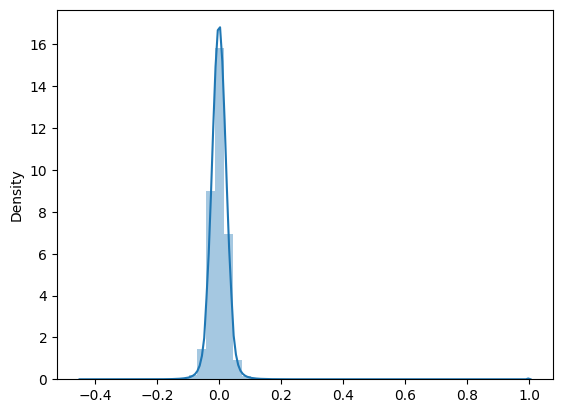

In [26]:
new_dict = {}
for key in model.state_dict():
    tensor = val = np.array(model.state_dict()[key])
    torch.nn.init.kaiming_uniform_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu')
    new_dict[key] = tensor
    
model.state_dict() = new_dict

In [18]:
def new_weights(module):
    if isinstance(module, nn.Conv2d):
        nn.init.kaiming_uniform_(module.weight, a=0, mode='fan_out', nonlinearity='leaky_relu')
    #    if module.bias is not None:
    #        nn.init.kaiming_uniform_(module.bias, a=0, mode='fan_out', nonlinearity='leaky_relu')
    #elif isinstance(module, (nn.BatchNorm2d, nn.GroupNorm)):
    #    nn.init.kaiming_uniform_(module.weight, a=0, mode='fan_out', nonlinearity='leaky_relu')
    #    nn.init.kaiming_uniform_(module.bias, a=0, mode='fan_out', nonlinearity='leaky_relu')
        
model.apply(new_weights)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/home/wtownle1/.conda/envs/encoder-dimensionality/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  import sys


<AxesSubplot:ylabel='Density'>

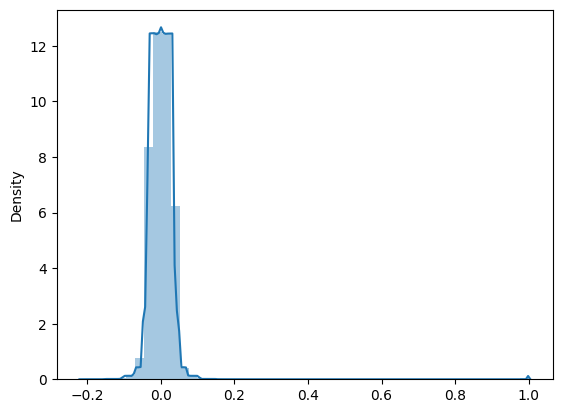

In [19]:
weights = []
for key in model.state_dict():
    val = np.array(model.state_dict()[key])
    val = np.ndarray.flatten(val)
    val = np.ndarray.tolist(val)
    weights = weights + val

sns.distplot(weights)

In [17]:

mod = mnasnet1_3(weights=None)

def new_ws(module):
    if isinstance(module, nn.Conv2d):
        nn.init.kaiming_uniform_(module.weight, a=0, mode='fan_out', nonlinearity='leaky_relu')
    #    if module.bias is not None:
    #        nn.init.kaiming_uniform_(module.bias, a=0, mode='fan_out', nonlinearity='leaky_relu')
    #elif isinstance(module, (nn.BatchNorm2d, nn.GroupNorm)):
    #    nn.init.kaiming_uniform_(module.weight, a=0, mode='fan_out', nonlinearity='leaky_relu')
    #    nn.init.kaiming_uniform_(module.bias, a=0, mode='fan_out', nonlinearity='leaky_relu')
        
mod.apply(new_ws)


In [7]:
resnet18_pt_layers = [f'layer1.{i}.relu' for i in range(2)] + \
                     [f'layer2.{i}.relu' for i in range(2)] + \
                     [f'layer3.{i}.relu' for i in range(2)] + \
                     [f'layer4.{i}.relu' for i in range(2)]

resnet50_pt_layers = [f'layer1.{i}.relu' for i in range(3)] + \
                     [f'layer2.{i}.relu' for i in range(4)] + \
                     [f'layer3.{i}.relu' for i in range(6)] + \
                     [f'layer4.{i}.relu' for i in range(3)]

alexnet_layers = [f"features.{i}" for i in [1, 4, 7, 9, 11]]

mnasnet_layers = [f"layers.{k}.{j}.layers.5" for k in range (8, 11) for j in range(3)] + \
    [f"layers.11.{j}.layers.5" for j in range(2)] + \
        [f"layers.12.{j}.layers.5" for j in range(4)] + \
            [f"layers.13.0.layers.5", "layers.16"]

regnet_layers = [f"trunk_output.block1.block1-0.activation"] + \
    [f"trunk_output.block2.block2-{i}.activation" for i in range(2)] + \
        [f"trunk_output.block3.block3-{i}.activation" for i in range(7)] + \
            [f"trunk_output.block4.block4-{i}.activation" for i in range(12)]

In [68]:
def uniform(m):
    if isinstance(m, nn.Conv2d):
        nn.init.uniform_(m.weight, a= -1.0, b=1.0)
        if m.bias is not None:
            nn.init.uniform_(m.bias, a=-1.0, b=1.0)
    if isinstance(m, nn.Linear):
        nn.init.uniform_(m.weight, a=-1.0, b=1.0)
        if m.bias is not None:
            nn.init.uniform_(m.bias, a=-1.0, b=1.0)

def models():
    model = resnet18(weights=None)
    model.apply(uniform)
    #model = wrap_pt(model, identifier)
    yield model, resnet18_pt_layers
    
    model = resnet50(weights=None)
    model.apply(uniform)
    #model = wrap_pt(model, identifier)
    yield model, resnet50_pt_layers
    
    model = alexnet(weights=None)
    model.apply(uniform)
    #model = wrap_pt(model, identifier)
    yield model, alexnet_layers
    
    model = mnasnet1_3(weights=None)
    model.apply(uniform)
    #model = wrap_pt(model, identifier)
    yield model, mnasnet_layers
    
    model = regnet_x_400mf(weights=None)
    model.apply(uniform)
    #model = wrap_pt(model, identifier)
    yield model, regnet_layers
    
    model = resnext50_32x4d(weights=None)
    model.apply(uniform)
    #model = wrap_pt(model, identifier)
    yield model, resnet50_pt_layers

def get_models():   
    for model, layers in models():
        yield model, layers

def check(m):
    if type(m) != nn.ReLU and type(m) != nn.MaxPool2d and type(m).__name__ != 'BasicBlock' and type(m) != nn.Sequential and type(m) != nn.AdaptiveAvgPool2d and type(m).__name__ != 'ResNet' and type(m).__name__ != 'Bottleneck' and type(m) != nn.Dropout and type(m).__name__ != 'AlexNet' and type(m).__name__ != 'MNASNet' and type(m).__name__ != '_InvertedResidual' and type(m).__name__ != 'SimpleStemIN' and type(m).__name__ != 'RegNet' and type(m).__name__ != 'Conv2dNormActivation' and type(m).__name__ != 'BottleneckTransform' and type(m).__name__ != 'ResBottleneckBlock' and type(m).__name__ != 'AnyStage':
        
        print(torch.isnan(m.weight).any())
        #if nw.item() == True:
        #    print('weight_nan')
        if type(m) != nn.Parameter:
            if m.bias is not None:

                print(torch.isnan(m.bias).any())
                #if nb.item() == True:
                #    print('bias_nan')
                

nan_check = []
for model, layers in get_models():
    print(model.__class__.__name__)
    model.apply(check)

ResNet
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
ResNet
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor

<bound method Module.children of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  